## Sparkified MainProj Notebook
Cambiar esta constante si necesita alojar menos memoria a spark

In [1]:
MAX_MEMORY = "5g"

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, regexp_extract, col, coalesce, lit, avg, mean
from pyspark.sql.types import *
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SparkifiedMainProj") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

25/08/07 14:12:43 WARN Utils: Your hostname, ALE-PCMR resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/07 14:12:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/07 14:12:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 1. Define explicit schemas for CSVs

In [3]:
# Replace the path with your actual GTD file path if needed
gtd_df = spark.read.csv("datasets/GTD.csv", header=True, inferSchema=True)

# Check schema
gtd_df.printSchema()


root
 |-- eventid: long (nullable = true)
 |-- iyear: integer (nullable = true)
 |-- imonth: integer (nullable = true)
 |-- iday: integer (nullable = true)
 |-- approxdate: string (nullable = true)
 |-- extended: integer (nullable = true)
 |-- resolution: timestamp (nullable = true)
 |-- country: integer (nullable = true)
 |-- country_txt: string (nullable = true)
 |-- region: integer (nullable = true)
 |-- region_txt: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- specificity: double (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- crit1: string (nullable = true)
 |-- crit2: string (nullable = true)
 |-- crit3: string (nullable = true)
 |-- doubtterr: string (nullable = true)
 |-- alternative: string (nullable = true)
 |-- alternative_txt: string (nullab

In [4]:
gtd_df = gtd_df.drop("eventid")

In [5]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, when
import re

def infer_and_cast_types(df, sample_size=100, prefix_rules=True):
    """
    Infers and casts types of columns in a Spark DataFrame based on prefix and sample values.
    
    Parameters:
    - df: Input Spark DataFrame
    - sample_size: Number of non-null samples per column to inspect
    - prefix_rules: If True, applies type rules based on column name prefixes like 'INT_', 'FLOAT_', 'BOOL_'
    
    Returns:
    - New DataFrame with casted columns
    """
    
    for col_name, dtype in df.dtypes:
        if dtype != 'string':
            continue  # Only attempt to cast string columns

        # Get sample non-null values
        sample_values = df.select(col_name).dropna().limit(sample_size).rdd.map(lambda r: r[0]).collect()
        
        # Skip if empty sample
        if not sample_values:
            continue

        # Use prefix rules if enabled
        if prefix_rules:
            if col_name.startswith("INT_") or col_name in ["n"]:
                df = df.withColumn(col_name, col(col_name).cast(IntegerType()))
                continue
            elif col_name.startswith("FLOAT_"):
                df = df.withColumn(col_name, col(col_name).cast(DoubleType()))
                continue
            elif col_name.startswith("BOOL_") or col_name in ["success", "extended", "suicide"]:
                df = df.withColumn(
                    col_name,
                    when(col(col_name).isin("1", "true", "True"), 1)
                    .when(col(col_name).isin("0", "false", "False"), 0)
                    .otherwise(None).cast(IntegerType())
                )
                continue

        # Infer based on values
        all_int = all(re.match(r'^-?\d+$', str(v)) for v in sample_values)
        all_float = all(re.match(r'^-?\d+(\.\d+)?$', str(v)) for v in sample_values)
        bool_like = all(str(v).strip() in ["0", "1", "true", "false", "True", "False"] for v in sample_values)

        if all_int:
            df = df.withColumn(col_name, col(col_name).cast(IntegerType()))
        elif all_float:
            df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

    return df


In [6]:
df = infer_and_cast_types(gtd_df, sample_size=100)
# Save as Parquet for efficient reloading
df.write.mode("overwrite").parquet("cleaned_gtd.parquet")
# Reload and verify schema again
cleaned_df = spark.read.parquet("cleaned_gtd.parquet")
cleaned_df.printSchema()

25/08/07 14:13:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


root
 |-- iyear: integer (nullable = true)
 |-- imonth: integer (nullable = true)
 |-- iday: integer (nullable = true)
 |-- approxdate: string (nullable = true)
 |-- extended: integer (nullable = true)
 |-- resolution: timestamp (nullable = true)
 |-- country: integer (nullable = true)
 |-- country_txt: string (nullable = true)
 |-- region: integer (nullable = true)
 |-- region_txt: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- specificity: double (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- crit1: integer (nullable = true)
 |-- crit2: integer (nullable = true)
 |-- crit3: integer (nullable = true)
 |-- doubtterr: integer (nullable = true)
 |-- alternative: double (nullable = true)
 |-- alternative_txt: string (nullable = true)
 |-- multiple: double 

In [7]:
# Como en este dataset la correlación era extremadamente baja, nos desharemos de todos los features que sean string (excepto el país)
# de esta forma se reduce bastante la complejidad del problema y facilita el entrenamiento de los modelos
from pyspark.sql.types import NumericType

def drop_non_numeric_columns(df, keep: list = []):
    """
    Drops all columns in the DataFrame that are not numeric, except those in `keep`.
    
    Parameters:
    - df: Spark DataFrame
    - keep: list of column names to keep even if non-numeric (e.g., ["country_txt"])
    
    Returns:
    - DataFrame with only numeric columns and the specified 'keep' columns
    """
    cols_to_keep = [field.name for field in df.schema.fields 
                if isinstance(field.dataType, NumericType) or field.name in keep]

    
    return df.select(cols_to_keep)


In [8]:
gtd_clean = drop_non_numeric_columns(cleaned_df, keep=["country_txt"])

### 2. Transform WGI DataFrame: melt, clean year & value

### 5. Correlation Matrix for GTD

In [9]:
gtd_clean.dtypes

[('iyear', 'int'),
 ('imonth', 'int'),
 ('iday', 'int'),
 ('extended', 'int'),
 ('country', 'int'),
 ('country_txt', 'string'),
 ('region', 'int'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('specificity', 'double'),
 ('vicinity', 'int'),
 ('crit1', 'int'),
 ('crit2', 'int'),
 ('crit3', 'int'),
 ('doubtterr', 'int'),
 ('alternative', 'double'),
 ('multiple', 'double'),
 ('success', 'int'),
 ('suicide', 'int'),
 ('attacktype1', 'int'),
 ('targtype1', 'int'),
 ('targsubtype1', 'double'),
 ('natlty1', 'double'),
 ('natlty3', 'double'),
 ('guncertain1', 'double'),
 ('individual', 'int'),
 ('nperps', 'double'),
 ('nperpcap', 'double'),
 ('claimed', 'double'),
 ('claimmode', 'double'),
 ('weaptype1', 'int'),
 ('weapsubtype1', 'double'),
 ('nkill', 'double'),
 ('nkillus', 'double'),
 ('nkillter', 'double'),
 ('nwound', 'double'),
 ('nwoundus', 'double'),
 ('nwoundte', 'double'),
 ('property', 'int'),
 ('propextent', 'double'),
 ('propvalue', 'double'),
 ('ishostkid', 'double'),
 ('n

Borrarlas estaba causando una gran pérdida de información, así que se usará imputación de datos

In [52]:
from pyspark.ml.feature import Imputer

numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

imputer = Imputer(
    inputCols=numeric_cols,
    outputCols=numeric_cols,
    strategy="mean"
)

In [53]:
df_imputed = imputer.fit(gtd_clean).transform(gtd_clean)

In [54]:
df_imputed.count()

209706

In [55]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assemble numeric features into a vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
vector_df = assembler.transform(df_imputed).select("features")

In [56]:
# Compute correlation matrix
correlation_matrix = Correlation.corr(vector_df, "features", method="pearson").head()[0].toArray()

In [57]:
corr_df = pd.DataFrame(correlation_matrix, columns=numeric_cols, index=numeric_cols)

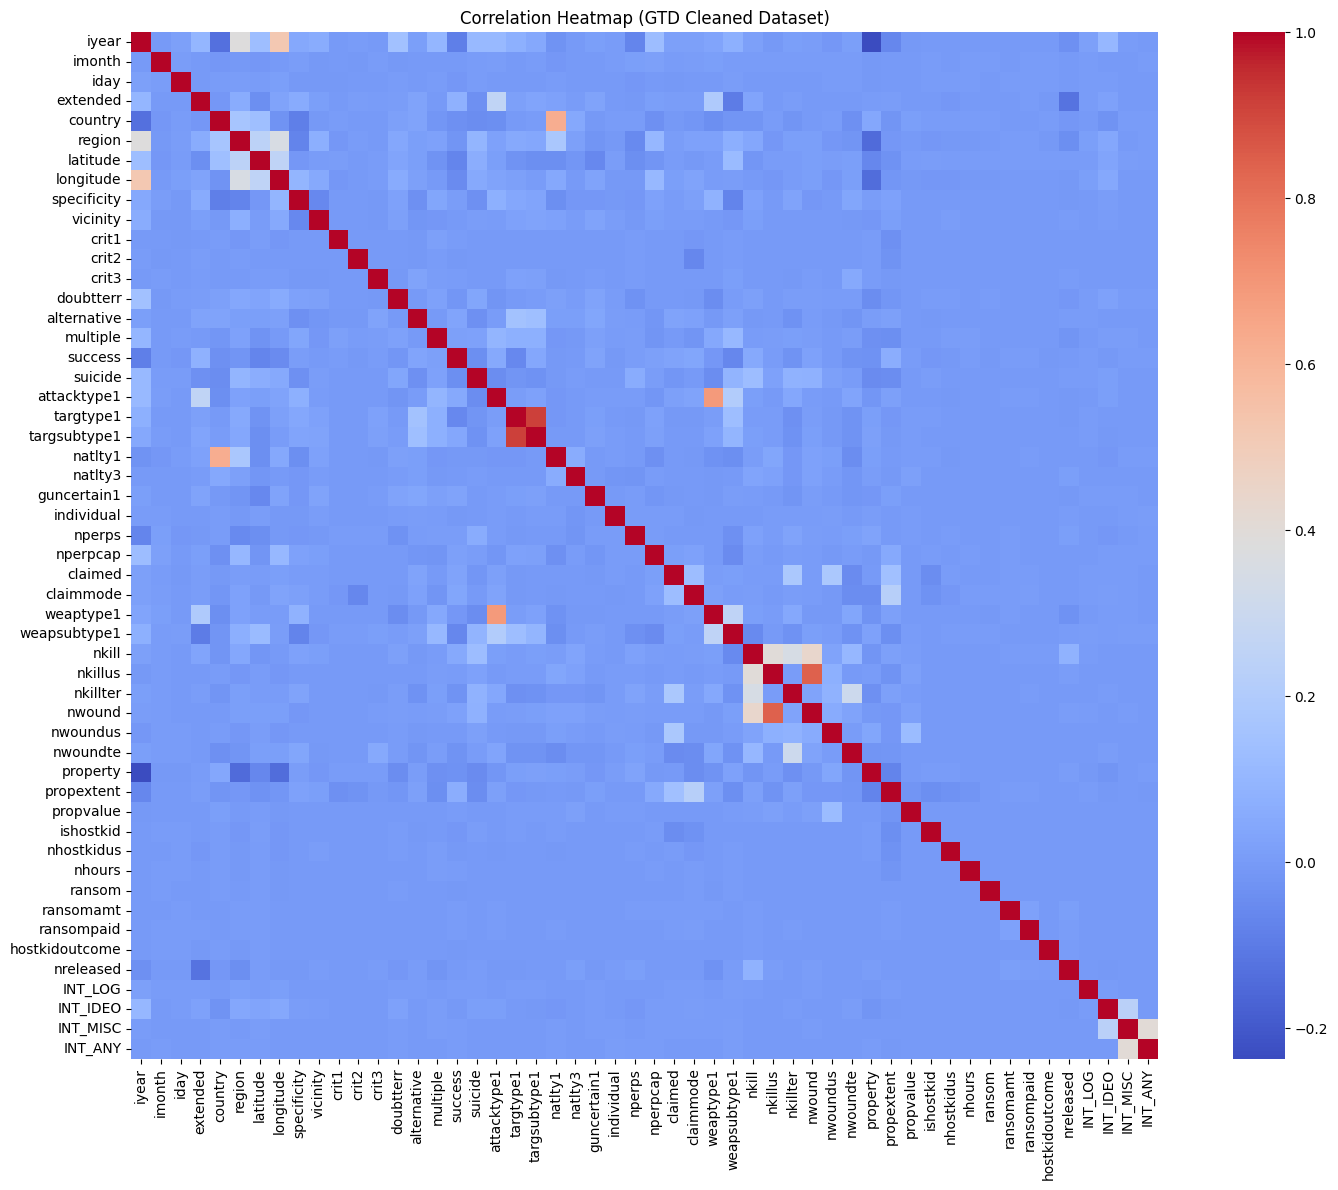

In [58]:

plt.figure(figsize=(16, 12))
sns.heatmap(corr_df, annot=False, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap (GTD Cleaned Dataset)")
plt.tight_layout()
plt.show()

### Aún con imputación se ve que la variable `success` tiene muy poca correlación con las demás por lo que nos conviene enriquecer el contexto.

In [63]:
# Load WGI without full schema, infer for non-prefix then cast later
wgi_raw = spark.read.option("header", True).csv("datasets/WGI.csv", inferSchema=True)
wgi_raw.show()

+--------------+------------+--------------------+-----------+------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+
|  Country Name|Country Code|         Series Name|Series Code|     1996 [YR1996]|     1998 [YR1998]|     2000 [YR2000]|       2002 [YR2002]|     2003 [YR2003]|      2004 [YR2004]|     2005 [YR2005]|     2006 [YR2006]|     2007 [YR2007]|     2008 [YR2008]|     2009 [YR2009]|     2010 [YR2010]|     2011 [YR2011]|     2012 [YR2012]|     2013 [YR2013]|      2014 [YR2014]|     2015 [YR2015]|     2016 [YR2016]|     2017 [YR2017]|     2018 [YR2018]|      2019

In [64]:
from pyspark.sql.functions import col, regexp_extract
from pyspark.sql.types import IntegerType, DoubleType

year_cols = [c for c in wgi_raw.columns if c.startswith("19") or c.startswith("20")]

stack_expr = "stack({0}, {1}) as (year, value)".format(
    len(year_cols),
    ", ".join([f"'{c}', `{c}`" for c in year_cols])
)

wgi_melted = wgi_raw.selectExpr(
    "`Country Name` as country_name",
    "`Country Code` as country_code",
    "`Series Name` as srs_name",
    "`Series Code` as srs_code",
    stack_expr
)

wgi_melted = wgi_melted.withColumn("year", regexp_extract("year", r"(\d{4})", 1).cast(IntegerType()))
wgi_melted = wgi_melted.withColumn("value", when(col("value") == "..", None).otherwise(col("value")))
wgi_melted = wgi_melted.withColumn("value", col("value").cast(DoubleType()))


In [67]:
# Se renombran algunas columnas para que sea mas facil manipularlas
rename_map = {
    "Government Effectiveness: Estimate": "gov_effectiveness",
    "Regulatory Quality: Estimate": "reg_qual",
    "Control of Corruption: Estimate": "ctrl_corruption",
    "Rule of Law: Estimate": "rule_law",
    "Voice and Accountability: Estimate": "voice_account",
    "Political Stability and Absence of Violence/Terrorism: Estimate": "pol_stability"
}

wgi_melted = wgi_melted.replace(rename_map, subset=["srs_name"])


In [68]:
from pyspark.sql.functions import first

wgi_pivoted = wgi_melted.groupBy("country_name", "year").pivot("srs_name").agg(first("value"))
wgi_pivoted.show()

+--------------------+----+------------------+------------------+------------------+-------------------+------------------+
|        country_name|year|   ctrl_corruption| gov_effectiveness|          reg_qual|           rule_law|     voice_account|
+--------------------+----+------------------+------------------+------------------+-------------------+------------------+
|            Colombia|2014|-0.397509813308716|-0.135854035615921| 0.444412022829056| -0.252291530370712|-0.043343797326088|
|Jersey, Channel I...|2011|  1.22138583660126|  1.44963026046753|  1.11898970603943|   1.73314356803894|   1.2762987613678|
|                Cuba|2009|   0.2748102247715|-0.336485356092453| -1.60246276855469| -0.712426066398621| -1.70388305187225|
|              Brazil|2023|-0.503643155097961|-0.546764314174652| -0.29647821187973| -0.308802843093872| 0.382853865623474|
|             Bermuda|2018|  1.17894005775452|  1.32700169086456| 0.813936293125153|  0.816772699356079|              null|
|       

In [69]:
# Join WGI with GTD
gtd_enriched = df_imputed.join(
    wgi_pivoted,
    (df_imputed["country_txt"] == wgi_pivoted["country_name"]) & (df_imputed["iyear"] == wgi_pivoted["year"]),
    how="inner"
)


In [70]:

enriched_renamed = gtd_enriched.selectExpr()
cols_to_impute = ["gov_effectiveness", "reg_qual"]

imputer = Imputer(
    inputCols=cols_to_impute,
    outputCols=cols_to_impute
)

gtd_enriched_imputed = imputer.fit(gtd_enriched).transform(gtd_enriched)

gtd_enriched_imputed.show()

+-----+------+----+--------+-------+-----------+------+---------+----------+-----------+--------+-----+-----+-----+---------+------------------+--------+-------+-------+-----------+---------+------------+------------------+------------------+-------------------+----------+-----------------+--------+--------------------+-----------------+---------+------------+------------------+-------------------+--------+------+--------+--------+--------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------+--------+--------+-------+------------+----+------------------+------------------+------------------+-------------------+------------------+
|iyear|imonth|iday|extended|country|country_txt|region| latitude| longitude|specificity|vicinity|crit1|crit2|crit3|doubtterr|       alternative|multiple|success|suicide|attacktype1|targtype1|targsubtype1|           natlty

In [90]:
gtd_enriched_imputed = gtd_enriched_imputed.drop("country_name")

In [91]:
total = gtd_enriched_imputed.count()

success_dist = gtd_enriched_imputed.groupBy("success").count()

success_dist.withColumn("%", (col("count") / total) * 100).show()

+-------+------+-----------------+
|success| count|                %|
+-------+------+-----------------+
|      1|106968|86.79508609078074|
|      0| 16274|13.20491390921926|
+-------+------+-----------------+



### Se puede ver que hay un gran desbalance de clases, así que procedemos con un remuestreo

Función para remuestreo

In [41]:
def submuestrear(df, label_col: str = "success"):
    
    majority_df = df.filter(col(label_col) == 1)
    minority_df = df.filter(col(label_col) == 0)

    
    ratio = minority_df.count() / majority_df.count()
    sampled_majority = majority_df.sample(withReplacement=False, fraction=ratio, seed=42)

    
    balanced_df = sampled_majority.union(minority_df)
    return balanced_df

In [92]:
balanced_data = submuestrear(gtd_enriched_imputed)

In [100]:
balanced_data.dtypes

[('iyear', 'int'),
 ('imonth', 'int'),
 ('iday', 'int'),
 ('extended', 'int'),
 ('country', 'int'),
 ('country_txt', 'string'),
 ('region', 'int'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('specificity', 'double'),
 ('vicinity', 'int'),
 ('crit1', 'int'),
 ('crit2', 'int'),
 ('crit3', 'int'),
 ('doubtterr', 'int'),
 ('alternative', 'double'),
 ('multiple', 'double'),
 ('success', 'int'),
 ('suicide', 'int'),
 ('attacktype1', 'int'),
 ('targtype1', 'int'),
 ('targsubtype1', 'double'),
 ('natlty1', 'double'),
 ('natlty3', 'double'),
 ('guncertain1', 'double'),
 ('individual', 'int'),
 ('nperps', 'double'),
 ('nperpcap', 'double'),
 ('claimed', 'double'),
 ('claimmode', 'double'),
 ('weaptype1', 'int'),
 ('weapsubtype1', 'double'),
 ('nkill', 'double'),
 ('nkillus', 'double'),
 ('nkillter', 'double'),
 ('nwound', 'double'),
 ('nwoundus', 'double'),
 ('nwoundte', 'double'),
 ('property', 'int'),
 ('propextent', 'double'),
 ('propvalue', 'double'),
 ('ishostkid', 'double'),
 ('n

Cabe notar que se puede también supermuestrear la clase con menos datos pero esto puede fácilmente llevar a mucho sobreajuste

## Pipeline de entrenamiento y evaluación

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [125]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexer = StringIndexer(inputCol="country_txt", outputCol="country_index", handleInvalid="keep")

# OneHotEncoder: country_index → country_vec
encoder = OneHotEncoder(inputCols=["country_index"], outputCols=["country_vec"])


In [127]:
# Get all columns except 'success'
feature_cols = [col for col in balanced_data.columns if col != "success"]

# Add the encoded column
feature_cols = [c for c in feature_cols if c != "country_txt"] + ["country_vec"]

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)


In [128]:
from pyspark.sql.functions import col

# Make sure label is integer (if not already)
df = balanced_data.withColumn("label", col("success").cast("integer"))


In [129]:
from pyspark.ml import Pipeline

preprocessing_pipeline = Pipeline(stages=[indexer, encoder, assembler])
df_encoded = preprocessing_pipeline.fit(df).transform(df)


Definición del evaluador: será clasificación binaria

In [134]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")


Función para evaluar los modelos

In [137]:
def evaluate_model(predictions, model_name="Model"):
    from pyspark.sql.functions import col, when, count

    # Accuracy & F1
    accuracy = accuracy_evaluator.evaluate(predictions)
    f1 = f1_evaluator.evaluate(predictions)
    auc = evaluator.evaluate(predictions)  # areaUnderROC

    # Confusion matrix components
    cm = predictions.select(
        when((col("label") == 1) & (col("prediction") == 1), 1).alias("TP"),
        when((col("label") == 0) & (col("prediction") == 1), 1).alias("FP"),
        when((col("label") == 0) & (col("prediction") == 0), 1).alias("TN"),
        when((col("label") == 1) & (col("prediction") == 0), 1).alias("FN")
    )

    counts = cm.selectExpr(
        "sum(TP) as TP", "sum(FP) as FP", "sum(TN) as TN", "sum(FN) as FN"
    ).collect()[0]

    TP = counts["TP"] or 0
    FP = counts["FP"] or 0
    TN = counts["TN"] or 0
    FN = counts["FN"] or 0

    precision = TP / (TP + FP) if TP + FP != 0 else 0.0
    recall = TP / (TP + FN) if TP + FN != 0 else 0.0

    print(f"\n Metrics for {model_name}:")
    print(f" - AUC:       {auc:.4f}")
    print(f" - Accuracy:  {accuracy:.4f}")
    print(f" - Precision: {precision:.4f}")
    print(f" - Recall:    {recall:.4f}")
    print(f" - F1 Score:  {f1:.4f}")


In [130]:
train_data, test_data = df_encoded.randomSplit([0.8, 0.2], seed=42)


### Definición de modelos y grids

Regr. Logística

In [131]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

In [ ]:
from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(featuresCol="features", labelCol="label")

paramGrid_lr = ParamGridBuilder() \
    .addGrid(log_reg.regParam, [0.01, 0.1, 1.0]) \
    .build()

crossval_lr = CrossValidator(
    estimator=log_reg,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator,
    numFolds=3
)

# Fit
cv_model_lr = crossval_lr.fit(train_data)

# Predict
predictions_lr = cv_model_lr.transform(test_data)


Logistic Regression AUC: 0.8660


Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label")

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

crossval_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=3
)

# Fit
cv_model_rf = crossval_rf.fit(train_data)

# Predict
predictions_rf = cv_model_rf.transform(test_data)



In [138]:
evaluate_model(predictions_lr, model_name="Logistic Regression")
evaluate_model(predictions_rf, model_name="Random Forest")



 Metrics for Logistic Regression:
 - AUC:       0.8660
 - Accuracy:  0.7917
 - Precision: 0.7900
 - Recall:    0.7848
 - F1 Score:  0.7916


25/08/07 16:51:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/08/07 16:51:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/08/07 16:51:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/08/07 16:51:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB



 Metrics for Random Forest:
 - AUC:       0.9643
 - Accuracy:  0.9128
 - Precision: 0.9310
 - Recall:    0.8883
 - F1 Score:  0.9127


## Análisis de las métricas y comparación de los modelos

---
### Capacidad para discriminar, según el AUC
el random forest le gana por mucho al logReg en AUC, con 0.96 vs 0.86, quiere decir que es mejor en dar verdaderos positivos sobre los falsos positivos.
Un AUC mayor que 0.9 nos dice que tiene una capacidad muy buena de distinguir entre ataques exitosos y fallidos

### Correctitud en general, con Accuracy

* el RF tiene 91.28% de los casos correctamente clasificados.
* la LR un 79.17%.

La diferencia de aproximadamente 12% significa que el random forest es mucho menos propenso a cometer errores

### Balance de los Errores (Precision vs Recall)
* De los casos exitosos, el random forest hizo mucho menos "falsos positivos", tiene 93.10% de precisión
* Recall: también tuvo muchísimo mejor rendimiento en encontrar los verdaderos ataques exitosos.


## Consideración del Sobreajuste

* Hay una consistencia en las métricas comparando entre el training y la validación, o sea, hay buena generalización, no se está acoplando demasiado al problema.
* No existe una brecha amplia entre el rendimiento de ambos, indicando que el afinamiento de hiperparámetros es correcto.


## Recomendaciones
* Utilizar el Random Forest si se necesita robustez en la clasificación, pero si se requiere una operación rápida y hay pocos recursos, puede valer la pena usar una regresión logística.


## Dificultades
* Deshacerse de features excesivos que no contribuían mucho al modelo tomó bastante tiempo y causó problemas a la hora de codificar la información.
* Un manejo más calculado desde el inicio podría haber prevenido estos contratiempos


fin del cuaderno